In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms # tv - popular datasets, model archs, common image transformations for CV
import torch.nn.functional as F # functions that are operate on tensors, not part of nn / not trainable params 
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pylab as plt

c:\Users\Vaishu\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
DATSET = './input'
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 1e-3
BATCH_SIZES = [1,256,128,64,32,16]
CHANNELS_IMG = 3
Z_DIm = 512
W_DIM = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [1] * len(BATCH_SIZES)

In [3]:
def get_loader(image_size):
    trainsform = transforms.Compose(
        [transforms.Resize((image_size, image_size)),  # 128x128 images
         transforms.ToTensor(),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], # mean
            [0.5 for _ in range(CHANNELS_IMG)], # std
         )
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size/4))]
    dataset = datasets.ImageFolder(root=DATSET, transform=trainsform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return loader, dataset

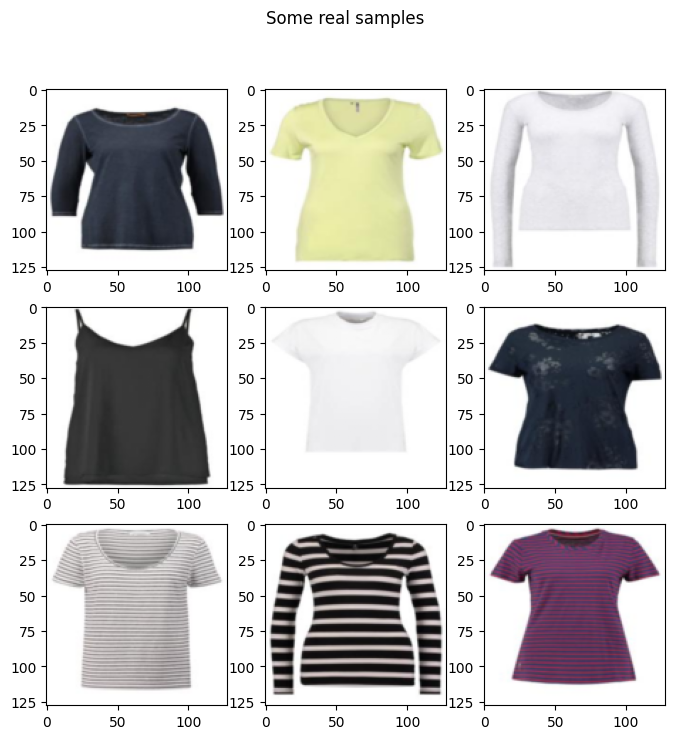

In [4]:
def check_loader():
    loader,_ = get_loader(128)
    cloth,_  = next(iter(loader))
    _,ax     = plt.subplots(3,3,figsize=(8,8))
    plt.suptitle('Some real samples')
    ind = 0
    for k in range(3):
        for kk in range(3):
            ax[k][kk].imshow((cloth[ind].permute(1,2,0)+1)/2)
            ind +=1
check_loader()  

In [5]:
# Noice apping network
# AdaIN
# Progressice growing
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32] # the number that will be multiplied with each channel

In [6]:
class WSLinear(nn.Module): # weighted square - consists of linear layer with weighted initialization
    def __init__(
        self, in_features, out_features
    ):
        super(WSLinear,self).__init__() # calls the constructor of the parent class nn.Module
        self.linear = nn.Linear(in_features, out_features)
        self.scale  = (2/in_features) ** 0.5
        self.bias   = self.linear.bias
        self.linear.bias = None # because bias is manually set

        nn.init.normal_(self.linear.weight) # weight is normaly distribution
        nn.init.zeros_(self.bias)

    def forward(self,x):
        return self.linear(x * self.scale) + self.bias

In [7]:
class PixenNorm(nn.Module):
    def __init__(self):
        super(PixenNorm, self).__init__()
        self.epsilon = 1e-8
    def forward(self,x ):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True)+  self.epsilon)

In [8]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            PixenNorm(),
            WSLinear(z_dim, w_dim), # instead of using in built linear layer
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
            nn.ReLU(),
            WSLinear(w_dim, w_dim),
        )
    
    def forward(self,x):
        return self.mapping(x)

In [10]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels) # IN layer applied to input tensor
        self.style_scale   = WSLinear(w_dim, channels)
        self.style_bias    = WSLinear(w_dim, channels)

    def forward(self,x,w):
        x = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3) # x undergoes scaling and biasing on the conditioning vector w
        style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * x + style_bias

In [11]:
class injectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

    def forward(self, x):
        noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
        return x + self.weight + noise

In [12]:
class GenBlock(nn.Module):
    def __init__(self, in_channel, out_channel, w_dim):
        super(GenBlock, self).__init__()
        self.conv1 = WSConv2d(in_channel, out_channel) # first conv layer with weighted scaling
        self.conv2 = WSConv2d(out_channel, out_channel)
        self.leaky = nn.LeakyReLU(0.2, inplace=True)
        self.inject_noise1 = injectNoise(out_channel)
        self.inject_noise2 = injectNoise(out_channel)
        self.adain1 = AdaIN(out_channel, w_dim)
        self.adain2 = AdaIN(out_channel, w_dim)
    def forward(self, x,w):
        x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
        x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
        return x

In [23]:
class Generator(nn.Module):
    def __init__(self, z_dim, w_dim, in_channels, img_channels=3):
        super().__init__()
        self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4,4))
        self.map = MappingNetwork(z_dim, w_dim)
        self.initial_adain1 = AdaIN(in_channels, w_dim)
        self.initial_adain2 = AdaIN(in_channels, w_dim)
        self.initial_noise1 = injectNoise(in_channels)
        self.initial_noise2 = injectNoise(in_channels)
        self.initial_conv   = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.leaky          = nn.LeakyReLU(0.2, inplace=True)

        self.initial_rgb    = WSConv2d(
            in_channels, img_channels, kernel_size = 1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb])
        )

        for i in range(len(factors)-1):
            conv_in_c  = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i+1])
            self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
            self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride=1, padding=0))
        
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha ) * upscaled)

    def forward(self, noise, alpha, steps):
        w = self.map(noise)
        print("shape :;;", w.shape)
        x = self.initial_adain1(self.initial_noise1(self.starting_cte),w)
        x = self.initial_conv(x)
        out = self.initial_adain2(self.leaky(self.initial_noise2(x)), w)
        print("out shape : ", out.shape)

        if steps == 0:
            return self.initial_rgb(x)
        
        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode = 'bilinear')
            out      = self.prog_blocks[step](upscaled,w)

        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out      = self.rgb_layers[steps](out)

        return self.fade_in(alpha, final_upscaled, final_out)

In [14]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.conv2(x))
        return x

In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [17]:
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, Z_DIM).to(DEVICE)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [18]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)
 
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [19]:
def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]
        noise = torch.randn(cur_batch_size, Z_DIm).to(DEVICE)
        fake  = gen(noise, alpha, step)
        critic_real = critic(real, alpha, step)
        critic_fake = critic(fake.detach(), alpha, step)
        gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
        loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        alpha += cur_batch_size / (
            PROGRESSIVE_EPOCHS[step] * 0.5 * len(dataset)
        )
        alpha = min(alpha,1)


        loop.set_postfix(
            gp = gp.item(),
            loss_critic = loss_critic.item()
        )
    return alpha

In [26]:
gen = Generator(
    Z_DIm, W_DIM, IN_CHANNELS, CHANNELS_IMG
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS_IMG).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1

Curent image size: 4
Epoch [1/ 1


  0%|          | 3/16240 [00:00<12:03, 22.43it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 9/16240 [00:00<09:52, 27.41it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 15/16240 [00:00<09:40, 27.94it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 21/16240 [00:00<09:26, 28.63it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 27/16240 [00:00<09:27, 28.57it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 30/16240 [00:01<10:20, 26.13it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 30/16240 [00:01<10:20, 26.13it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 36/16240 [00:01<17:57, 15.03it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 42/16240 [00:01<14:08, 19.09it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 42/16240 [00:02<14:08, 19.09it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 42/16240 [00:02<14:08, 19.09it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 45/16240 [00:02<29:46,  9.06it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 50/16240 [00:03<23:11, 11.63it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 53/16240 [00:03<19:13, 14.03it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 56/16240 [00:03<21:34, 12.51it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 56/16240 [00:03<21:34, 12.51it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 58/16240 [00:03<33:51,  7.96it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 58/16240 [00:04<33:51,  7.96it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 60/16240 [00:04<45:25,  5.94it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 60/16240 [00:04<45:25,  5.94it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 62/16240 [00:05<54:04,  4.99it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 63/16240 [00:05<58:13,  4.63it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 64/16240 [00:05<1:02:03,  4.34it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 65/16240 [00:06<1:05:12,  4.13it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 66/16240 [00:06<1:07:34,  3.99it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 67/16240 [00:06<1:10:09,  3.84it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 68/16240 [00:06<1:12:27,  3.72it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 69/16240 [00:07<1:14:26,  3.62it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 70/16240 [00:07<1:16:18,  3.53it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 71/16240 [00:07<1:18:51,  3.42it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 72/16240 [00:08<1:21:43,  3.30it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 73/16240 [00:08<1:19:16,  3.40it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 74/16240 [00:08<1:20:08,  3.36it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 75/16240 [00:09<1:20:47,  3.34it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 76/16240 [00:09<1:20:58,  3.33it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 77/16240 [00:09<1:20:13,  3.36it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 78/16240 [00:09<1:20:02,  3.37it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 79/16240 [00:10<1:19:46,  3.38it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 80/16240 [00:10<1:17:15,  3.49it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  0%|          | 81/16240 [00:10<1:21:43,  3.30it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 82/16240 [00:11<1:26:05,  3.13it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 83/16240 [00:11<1:18:33,  3.43it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 84/16240 [00:11<1:11:17,  3.78it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 85/16240 [00:11<1:08:28,  3.93it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 86/16240 [00:12<1:08:14,  3.95it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 87/16240 [00:12<1:05:16,  4.12it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 88/16240 [00:12<1:01:32,  4.37it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 89/16240 [00:12<59:36,  4.52it/s, gp=nan, loss_critic=nan]  

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 90/16240 [00:13<58:44,  4.58it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 91/16240 [00:13<57:13,  4.70it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 92/16240 [00:13<56:37,  4.75it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 93/16240 [00:13<56:26,  4.77it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 94/16240 [00:13<56:14,  4.78it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 95/16240 [00:14<55:51,  4.82it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 96/16240 [00:14<55:15,  4.87it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 97/16240 [00:14<55:24,  4.86it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 98/16240 [00:14<55:34,  4.84it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 99/16240 [00:14<55:55,  4.81it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 100/16240 [00:14<54:48,  4.91it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 101/16240 [00:15<56:13,  4.78it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 102/16240 [00:15<58:03,  4.63it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 103/16240 [00:15<59:42,  4.50it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 104/16240 [00:15<1:01:22,  4.38it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 105/16240 [00:16<1:00:12,  4.47it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 106/16240 [00:16<57:56,  4.64it/s, gp=nan, loss_critic=nan]  

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 107/16240 [00:16<56:18,  4.77it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 108/16240 [00:16<55:03,  4.88it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 109/16240 [00:17<53:42,  5.01it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 110/16240 [00:17<53:23,  5.04it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 111/16240 [00:17<53:26,  5.03it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 112/16240 [00:17<53:24,  5.03it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 113/16240 [00:17<53:46,  5.00it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 114/16240 [00:18<53:53,  4.99it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 115/16240 [00:18<53:37,  5.01it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 116/16240 [00:18<54:49,  4.90it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 117/16240 [00:18<54:46,  4.91it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 118/16240 [00:18<54:48,  4.90it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 119/16240 [00:19<53:28,  5.03it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 120/16240 [00:19<53:20,  5.04it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 121/16240 [00:19<53:34,  5.01it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 122/16240 [00:19<54:27,  4.93it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 123/16240 [00:19<56:02,  4.79it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 124/16240 [00:19<56:43,  4.74it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 125/16240 [00:20<57:48,  4.65it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 126/16240 [00:20<57:47,  4.65it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 127/16240 [00:20<56:01,  4.79it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 128/16240 [00:20<55:07,  4.87it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 129/16240 [00:21<54:36,  4.92it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 130/16240 [00:21<55:07,  4.87it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 131/16240 [00:21<54:38,  4.91it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 132/16240 [00:21<55:48,  4.81it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 133/16240 [00:22<1:15:18,  3.56it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 134/16240 [00:22<1:17:53,  3.45it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 135/16240 [00:22<1:14:03,  3.62it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 136/16240 [00:22<1:10:58,  3.78it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 137/16240 [00:23<1:13:49,  3.64it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 138/16240 [00:23<1:12:45,  3.69it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 139/16240 [00:23<1:18:08,  3.43it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 140/16240 [00:24<1:21:54,  3.28it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 141/16240 [00:24<1:19:36,  3.37it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 142/16240 [00:24<1:19:23,  3.38it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 143/16240 [00:24<1:21:43,  3.28it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 144/16240 [00:25<1:20:49,  3.32it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 145/16240 [00:25<1:20:18,  3.34it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 146/16240 [00:25<1:29:41,  2.99it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 147/16240 [00:26<1:22:48,  3.24it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 148/16240 [00:26<1:17:05,  3.48it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 149/16240 [00:26<1:10:27,  3.81it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 150/16240 [00:27<1:05:40,  4.08it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 151/16240 [00:27<1:02:39,  4.28it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 152/16240 [00:27<1:00:55,  4.40it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 153/16240 [00:27<1:01:37,  4.35it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 154/16240 [00:27<1:00:58,  4.40it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 155/16240 [00:27<1:00:33,  4.43it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 156/16240 [00:28<59:36,  4.50it/s, gp=nan, loss_critic=nan]  

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 157/16240 [00:28<57:39,  4.65it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 158/16240 [00:28<56:44,  4.72it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 159/16240 [00:28<55:04,  4.87it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 160/16240 [00:29<53:34,  5.00it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 161/16240 [00:29<53:00,  5.06it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 162/16240 [00:29<1:04:54,  4.13it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 164/16240 [00:29<1:00:53,  4.40it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])
shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 165/16240 [00:30<1:02:50,  4.26it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 166/16240 [00:30<1:17:40,  3.45it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 167/16240 [00:30<1:17:03,  3.48it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 168/16240 [00:31<1:16:40,  3.49it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 169/16240 [00:31<1:17:15,  3.47it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 170/16240 [00:31<1:18:46,  3.40it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 171/16240 [00:32<1:26:14,  3.11it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 172/16240 [00:32<1:22:49,  3.23it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 173/16240 [00:32<1:24:14,  3.18it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 174/16240 [00:33<1:23:32,  3.21it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 175/16240 [00:33<1:20:08,  3.34it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 176/16240 [00:33<1:19:39,  3.36it/s, gp=nan, loss_critic=nan]

shape :;; torch.Size([1, 512])
out shape :  torch.Size([1, 512, 4, 4])


  1%|          | 176/16240 [00:33<51:36,  5.19it/s, gp=nan, loss_critic=nan]  


KeyboardInterrupt: 